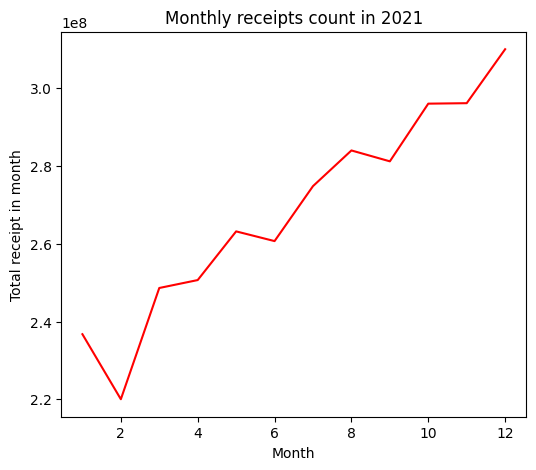

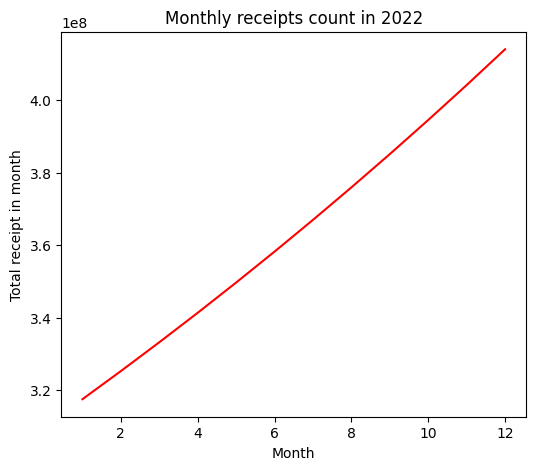

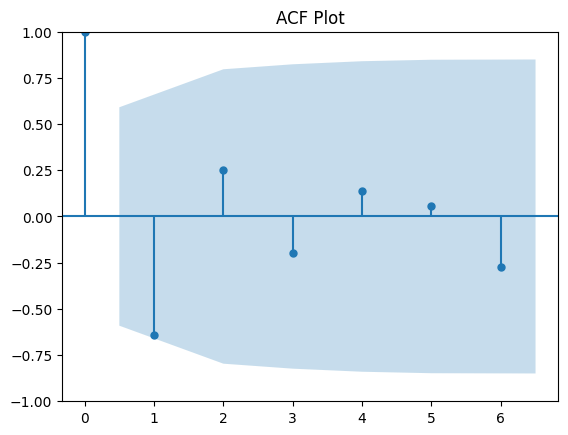

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf, adfuller

class Arima_module(torch.nn.Module):
    # The current value is a function of the prev value
    # A(t) = a*A(t-1)+ e
    def __init__(self, d= 1):
        super(Arima_module, self).__init__()
        self.alpha = torch.rand(1, requires_grad= True)
        self.phi = torch.rand(1, requires_grad= True)
        self.drift = torch.rand(1, requires_grad= True)
        self.theta = torch.rand(1, requires_grad= True)
        self.d = d

    def difference(self, data):
        diff = pd.Series(data.numpy()).diff(self.d).dropna().values
        return torch.tensor(diff, dtype = torch.float32)

    def reverse_difference(self, last_obs, diff_value):
        return last_obs + diff_value

    def forward_prob(self, diff_data, error):
        # AR(1): Y_t = alpha + \phi Y_{t-1}+ \theta * error + d
        #diff_data = self.difference(obs_data) #difference the orignal data 1 time
        x = self.alpha + self.phi*diff_data + self.theta*error + self.drift
        return x
    
    # obs_data is the original data
    def ml_fit(self, obs_data, num_iterations = 100, momentum = 0.9, lr = 0.01):
        diff_data = self.difference(obs_data) #difference the orignal data 1 time
        param = torch.tensor([self.alpha, self.phi, self.drift], requires_grad=True)
        optimizer = torch.optim.SGD([param], lr = lr, momentum= momentum)
        error = torch.zeros_like(diff_data)
        for values in range(num_iterations):
            for t in range(1, len(diff_data)):
                error[t] = diff_data[t] - self.forward_prob(diff_data[t-1], error[t-1])
            loss_fn = self.likelihood_fun(param, diff_data.clone())
            loss_fn.mean().backward(retain_graph = True)
            optimizer.step()
            optimizer.zero_grad()
        return

    def likelihood_fun(self, param, diff_data):
        sum = 0
        alpha = param[0]
        phi = param[1]
        drift = param[2]
        for val in diff_data:
            sum = sum + phi*val + alpha + drift
        return -sum

    def params(self):
        return self.alpha, self.phi, self.drift

    def predict_2022(self, obs_data, num_month = 13):
        predictions = []
        error = 0
        for month in range(1, num_month):
            pred_diff = self.forward_prob(obs_data[-1], error)
            pred = self.reverse_difference(obs_data[-1].item(), pred_diff.item())
            predictions.append(pred)
            obs_data = torch.cat((obs_data, torch.tensor([pred], dtype=torch.float32)))
        return predictions

def plot_df(x, y, title = "", xlabel = 'Month', ylabel = 'Total receipt in month', dpi = 100):
    plt.figure(figsize=(6,5), dpi = dpi)
    plt.plot(x, y, color='red')
    plt.gca().set(title = title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
def PlotAcf(data_series):
    #print(acf(data_series, nlags = 6))
    plot_acf(data_series, lags = 6)
    plt.title('ACF Plot')
    plt.show()
    
def Plot_Pafc(data_series):
    #print(pacf(data_series, nlags = 4))
    plot_pacf(data_series, lags = 4)
    plt.title('PACF Plot')
    plt.show()

def train_evaluate_model(train_df, test_df, lr = 0.01, num_iterations = 5000, momentum = 0.9):
    model = Arima_module()
    obs_data = torch.tensor(train_df, dtype = torch.float32)
    model.ml_fit(obs_data, num_iterations= num_iterations, momentum = momentum, lr = lr)
    predictions = model.predict_2022(obs_data, num_month= 4)
    mse = np.mean((predictions - test_df)**2)
    return mse, model
    
def load_data(file_pattern):
    '''
    Load data and preprocessing data
    '''
    df = pd.read_csv(file_pattern)
    df['Date'] = pd.to_datetime(df['# Date'])
    df['Month']= df['Date'].dt.month
    df = df.drop(columns= ['# Date', 'Date'])
    train = df.groupby(['Month']).sum().reset_index()
    data_series = train["Receipt_Count"]
    return train, data_series[:-3], data_series[-3:] 

    
if __name__ == "__main__":
    ###################################LOAD DATA##########################################
    df_full, df, df_test = load_data('data_daily.csv')
    
    param_grid = {
    'lr': [0.001, 0.01, 0.1],
    'num_iterations': [1000, 5000, 10000],
    'momentum': [0.5,0.7, 0.9]
    }
    
    best_mse = float('inf')
    best_params = None
    best_model = None
    
    for lr in param_grid['lr']:
        for num_iterations in param_grid['num_iterations']:
            for c in param_grid['momentum']:
                    mse, model = train_evaluate_model(df, df_test, lr = lr, num_iterations = num_iterations, momentum= c)
                    if mse < best_mse:
                        best_model = model
                        best_mse = mse
                        best_params = best_model.params()
    
    #Plot 2021          
    plot_df(x=df_full['Month'].values, y= df_full['Receipt_Count'].values, title='Monthly receipts count in 2021')
    #Plot 2022
    values = best_model.predict_2022(torch.tensor(df_full['Receipt_Count'].values, dtype = torch.float32))
    plot_df(x=df_full['Month'].values, y= values, title='Monthly receipts count in 2022')
    
    data_series = df_full['Receipt_Count']
    train_after_diff = data_series.diff().dropna().values
    #Plot ACF
    PlotAcf(train_after_diff)
    #Plot PACF
    torch.save(best_model.state_dict(), 'best_model.pth')

In [3]:
best_mse

41156215552170.5